# Домашнее задание №2

Импортировать необходимые пакеты.

In [1]:
import typing as t
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
plt.rcParams["figure.figsize"] = (8, 6)
sns.set()

np.random.seed(47)

warnings.filterwarnings("ignore")

## Часть 1. EDA и Preprocessing

Загрузим набор данных.

In [3]:
data_path = Path.cwd().parent.joinpath("data", "german_credit_data.csv")

df = pd.read_csv(data_path, index_col=0)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


Описание атрибутов датасета: 

1. Age (numeric)
2. Sex (text: male, female)
3. Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
4. Housing (text: own, rent, or free)
5. Saving accounts (text - little, moderate, quite rich, rich)
6. Checking account (numeric, in DM - Deutsch Mark)
7. Credit amount (numeric, in DM)
8. Duration (numeric, in month)
9. Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

Получим информацию о датасете.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 78.1+ KB


В столбцах Saving accounts и Checking accounts присутсвуют пропуски. Удалим пропуски для соответствующих атрибутов. 

#### Удаление пропусков значений атрибута *Saving accounts*

Построим гистограмму распределения значений атрибута без учета пропусков.

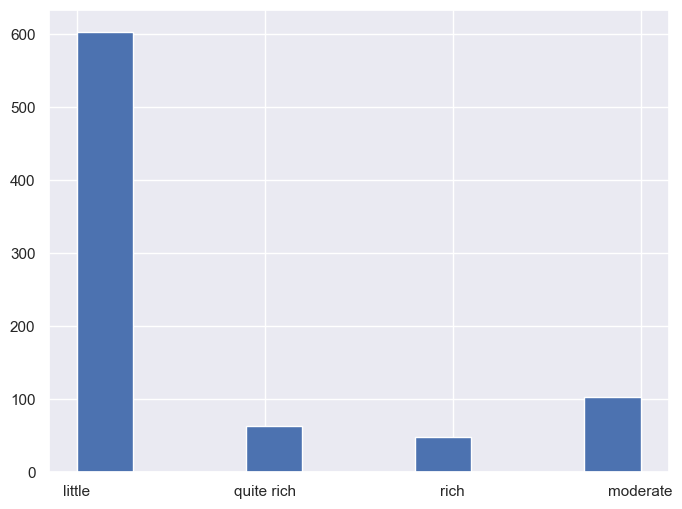

In [5]:
df["Saving accounts"].dropna().hist();

Очевидно, для данного атрибута значение *little* для данного атрибута является модальным, причем количество значений *little* значительно превышает количество остальных значений атрибута *Saving accounts*. Иcходя из этого, заменим пропущенные значения этого атрибута значением моды *little*.

In [6]:
df.loc[df["Saving accounts"].isna(), "Saving accounts"] = (
    df["Saving accounts"].dropna().mode()[0]
)

Отобразим информацию о датасете.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   1000 non-null   object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 78.1+ KB


#### Удаление пропусков значений атрибута *Checking account*

Построим гистограмму распределения значений атрибута без учета пропусков.

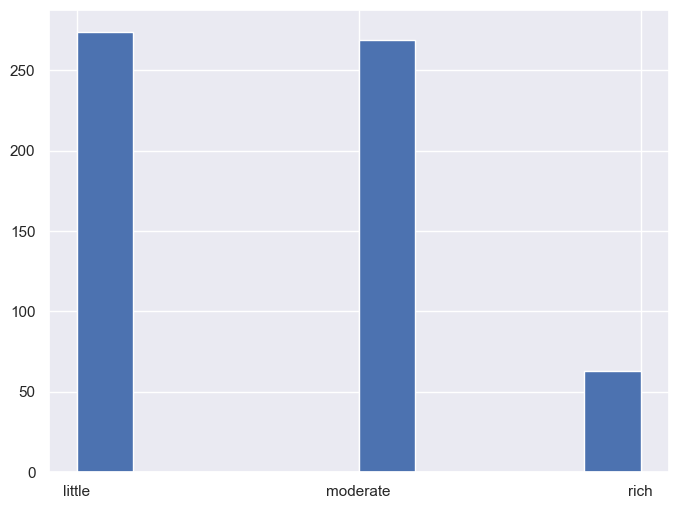

In [8]:
checking_account = df["Checking account"].dropna()
checking_account.hist();

Как видно из гистограммы, для данного атрибута отсутствует какое-либо ярко выраженное значение, поэтому заполним строки с незаданными значениями случайными значениями атрибута, сохранив при этом распределение значений. Для этого вначале определим пороги для вычисления значений:

In [9]:
tresholds = (checking_account.value_counts() / checking_account.count()).sort_values(
    ascending=False
).cumsum()

tresholds

little      0.452145
moderate    0.896040
rich        1.000000
Name: Checking account, dtype: float64

Определим и применим функцию для генерации значений атрибута.

In [10]:
@np.vectorize
def checking_account_gen(value: t.Optional[str]) -> str:
    if value in tresholds.index:
        return value
    
    r = np.random.rand()
    for idx, (key, treshold) in enumerate(tresholds.items()):
        if idx < tresholds.count() - 1:
            if r <= treshold:
                return key
        else:
            return key

In [11]:
df.loc[:, "Checking account"] = df["Checking account"].apply(checking_account_gen)

In [12]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,little,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,rich,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


Отобразим информацию о датасете.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   1000 non-null   object
 5   Checking account  1000 non-null   object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 78.1+ KB


Построим гистограмму значений признака после заполнения незаданных значений:

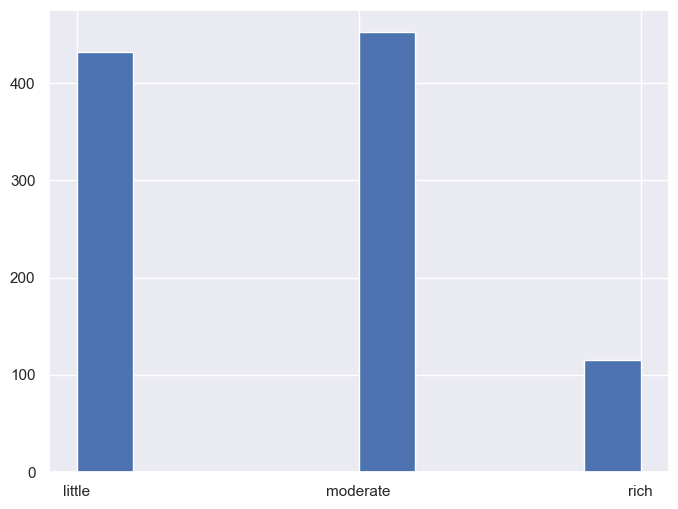

In [14]:
df["Checking account"].hist();

Таким образом, после заполнения пропущенных значений распределение значений данного атрибута примерно соответствует исходному распределению заданных априори значений.

#### Предобработка атрибутов с числовыми значениями

Выберем атрибуты с числовыми значениями.

In [15]:
df_numeric = df.select_dtypes(include=("int64", ))

Удалить колонку *Job* поскольку она является категориальной по сути.

In [16]:
df_numeric.drop("Job", axis=1, inplace=True)

Отобразить информацию о датасете.

In [17]:
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Age            1000 non-null   int64
 1   Credit amount  1000 non-null   int64
 2   Duration       1000 non-null   int64
dtypes: int64(3)
memory usage: 31.2 KB


Пропусков нет, все поля являются числовыми. Построить pairplot и correlation map для выявления зависимых признаков.

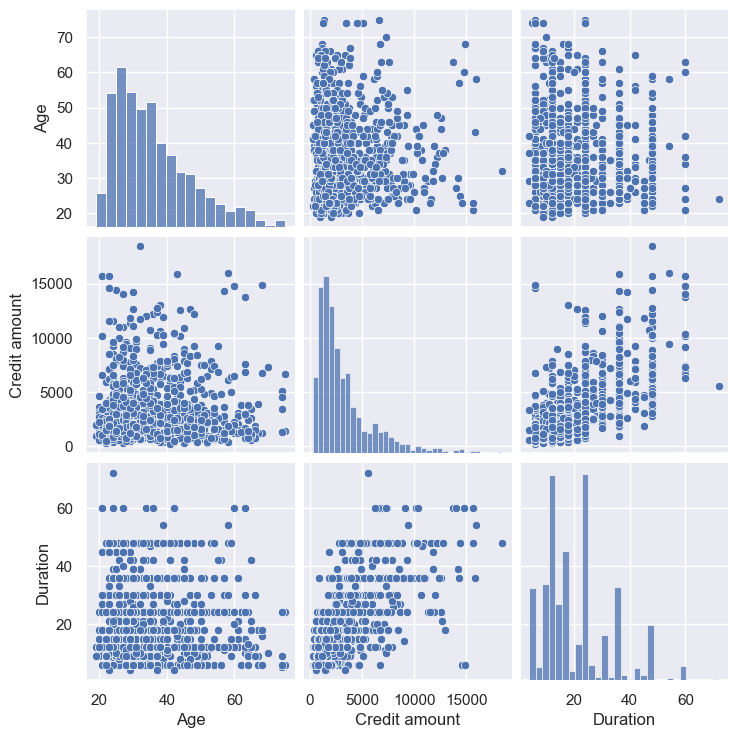

In [18]:
sns.pairplot(df_numeric);

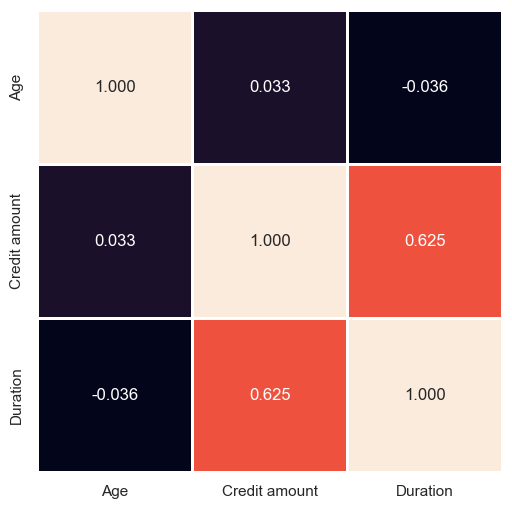

In [19]:
plt.figure(figsize=(6, 6))
sns.heatmap(df_numeric.corr(), annot=True, cbar=False, linewidth=1, fmt=".3f")
plt.show()

Значения всех числовых признаков слабо связаны друг с другом, за исключением признаков *Credit amount* и *Duration*. Данная зависимость может быть объяснена тем, что обычно большие суммы денег берутся на более большой срок. 

Согласно материалам статьи [Кластеризация: алгоритмы k-means и c-means](https://habr.com/ru/post/67078/):

**Кластеризация** — это разделение множества входных векторов на группы (кластеры) по степени «схожести» друг на друга... Для того, чтобы сравнивать два объекта, необходимо иметь критерий, на основании которого будет происходить сравнение. Как правило, таким критерием является расстояние между объектами. Расстояние между объектами в значительной степени зависит от используемой шкалы. При этом достаточно большие значения одного какого-либо признака могут практически свести к нулю влияние на конечную оценку расстояния других признаков. Поэтому очень важно выполнять масштабирование признаков перед выполнением кластеризации.

Все данных признаки находятся в разном числовом масштабе. Для успешной кластеризации выполним масштабирование этих признаков:

In [20]:
scaler = StandardScaler()

df_scaled = pd.DataFrame(
    data=scaler.fit_transform(df_numeric),
    index=df_numeric.index,
    columns=df_numeric.columns,
)
df_scaled.head()

,Age,Credit amount,Duration
0,2.766456,-0.745131,-1.236478
1,-1.191404,0.949817,2.248194
2,1.183312,-0.416562,-0.738668
3,0.831502,1.634247,1.750384
4,1.535122,0.566664,0.256953


#### Предобработка атрибутов с категориальными значениями

Выберем атрибуты с категориальными значениями.

In [21]:
df_cat = df.select_dtypes(include=("object", ))
df_cat.head()

,Sex,Housing,Saving accounts,Checking account,Purpose
0,male,own,little,little,radio/TV
1,female,own,little,moderate,radio/TV
2,male,own,little,rich,education
3,male,free,little,little,furniture/equipment
4,male,free,little,little,car


Выполнить OneHot кодирование категориальных признаков.

In [22]:
df_dummy = pd.get_dummies(df_cat, drop_first=True).astype(np.float64)
df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Sex_male                     1000 non-null   float64
 1   Housing_own                  1000 non-null   float64
 2   Housing_rent                 1000 non-null   float64
 3   Saving accounts_moderate     1000 non-null   float64
 4   Saving accounts_quite rich   1000 non-null   float64
 5   Saving accounts_rich         1000 non-null   float64
 6   Checking account_moderate    1000 non-null   float64
 7   Checking account_rich        1000 non-null   float64
 8   Purpose_car                  1000 non-null   float64
 9   Purpose_domestic appliances  1000 non-null   float64
 10  Purpose_education            1000 non-null   float64
 11  Purpose_furniture/equipment  1000 non-null   float64
 12  Purpose_radio/TV             1000 non-null   float64
 13  Purpose_repairs    

Следует обратить внимание на то, что были удалены признаки, значения которых могут быть однозначно определены по значениям представленных признаков. Для категориальных признаков нет смысла выполнять масштабирование, поскольку значения данных сопоставимы с нормализованными значениями числовых признаков.

#### Формирование набора данных для последующей обработки

In [23]:
df_new = pd.concat([df_scaled, df.loc[:, "Job"].astype(np.float64), df_dummy], axis=1)

Получить информацию о сформированнном наборе данных.

In [24]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Age                          1000 non-null   float64
 1   Credit amount                1000 non-null   float64
 2   Duration                     1000 non-null   float64
 3   Job                          1000 non-null   float64
 4   Sex_male                     1000 non-null   float64
 5   Housing_own                  1000 non-null   float64
 6   Housing_rent                 1000 non-null   float64
 7   Saving accounts_moderate     1000 non-null   float64
 8   Saving accounts_quite rich   1000 non-null   float64
 9   Saving accounts_rich         1000 non-null   float64
 10  Checking account_moderate    1000 non-null   float64
 11  Checking account_rich        1000 non-null   float64
 12  Purpose_car                  1000 non-null   float64
 13  Purpose_domestic ap

Таким образом, после предобработки все атрибуты являются числовыми, пропуски данных отсутствуют.

## Часть 2. Моделирование

### Предварительная визуализация данных

Выполним визуализацию данных различными методами для предварительной оценки наличия кластеров в данных.

#### PCA

In [25]:
x_pca = PCA(n_components=2).fit_transform(df_new.values)
x_pca.shape

(1000, 2)

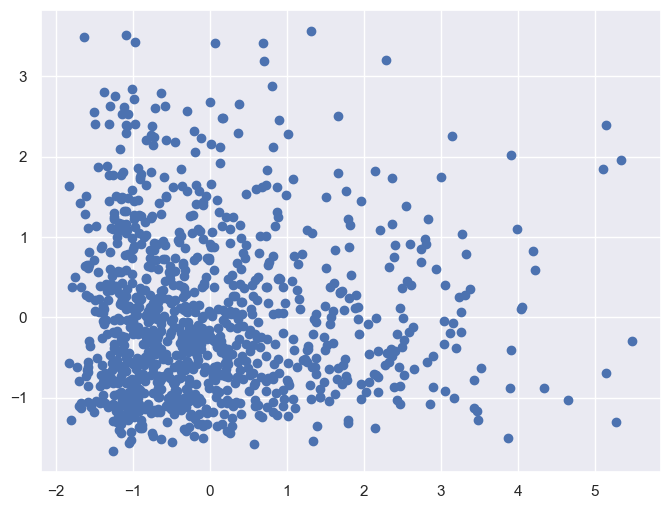

In [26]:
plt.scatter(x_pca[:, 0], x_pca[:, 1]);

На основании результатов визуализации с помощью метода PCA достаточно трудно выделить какие-либо кластеры в данных.

#### t-SNE

In [27]:
tsne = TSNE(n_components=2, random_state=47, n_jobs=-1)

x_tsne = tsne.fit_transform(df_new.values)
x_tsne.shape

(1000, 2)

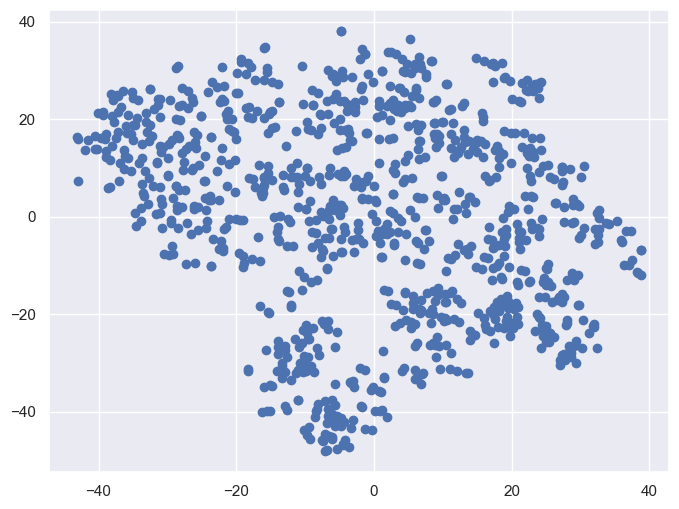

In [28]:
plt.scatter(x_tsne[:, 0], x_tsne[:, 1]);

На основании результатов визуализации с помощью метода t-SNE можно различить несколько кластеров данных.

#### UMAP

In [29]:
reducer = umap.UMAP(random_state=47)

x_umap = reducer.fit_transform(df_new.values)
x_umap.shape

(1000, 2)

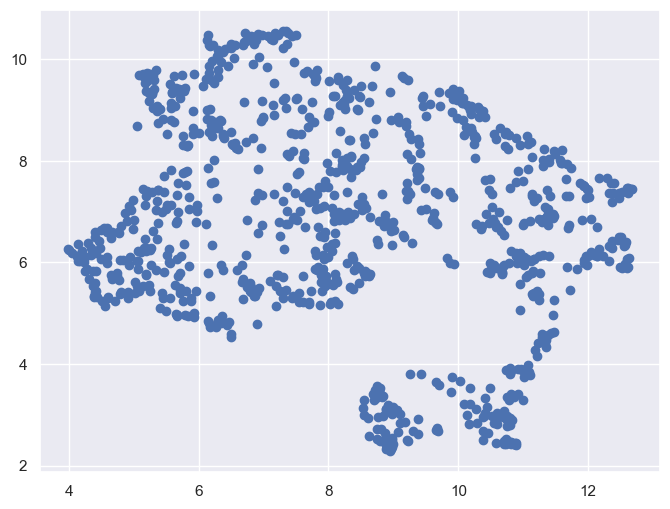

In [30]:
plt.scatter(x_umap[:, 0], x_umap[:, 1]);

На основании результатов визуализации с помощью метода UMAP можно различить несколько кластеров данных.